In [1]:
from Python.tigre.utilities.io.VarianDataLoader import (
    VarianDataLoader
)
from Python.tigre.algorithms.single_pass_algorithms import FDK
import numpy as np
import matplotlib.pyplot as plt

In [2]:
mydir = "C:/CBCT_Scatter_Removal_Project/data/clinical/4100758/2021-07-06_101037/11528a87-b894-4239-846d-45d8fd1efeda"

In [3]:
log_projs,geometry,angles = VarianDataLoader(mydir,sc=1,dps=1)

Loading Varian CBCT dataset: C:/CBCT_Scatter_Removal_Project/data/clinical/4100758/2021-07-06_101037/11528a87-b894-4239-846d-45d8fd1efeda\Acquisitions


100%|██████████| 900/900 [02:51<00:00,  5.24it/s]


Performing detector point scatter correction: 


10it [00:08,  1.20it/s]


Performing detector point scatter correction: 


887it [12:41,  1.16it/s]


Performing ASKS scatter correction: 


887it [11:31,  1.28it/s]


Performing log normalization:


100%|██████████| 887/887 [00:07<00:00, 125.82it/s]


Performing ring artifact correction:


100%|██████████| 887/887 [01:04<00:00, 13.72it/s]


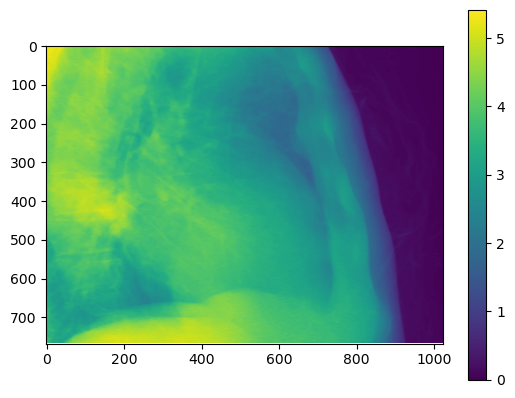

In [4]:
plt.imshow(log_projs[00])
plt.colorbar()

In [ ]:
np.save('./data/proj_sks2.npy',log_projs)


In [5]:
recon=FDK(log_projs,geometry,angles,verbose=True)

FDK: applying detector offset weights


c:\Users\MedPhys\anaconda3\envs\tigre\lib\site-packages\tigre\utilities\filtering.py:73: UserWarning: no filter selected, using default ram_lak
  warnings.warn("no filter selected, using default ram_lak")


In [6]:
recon[recon<0]=0

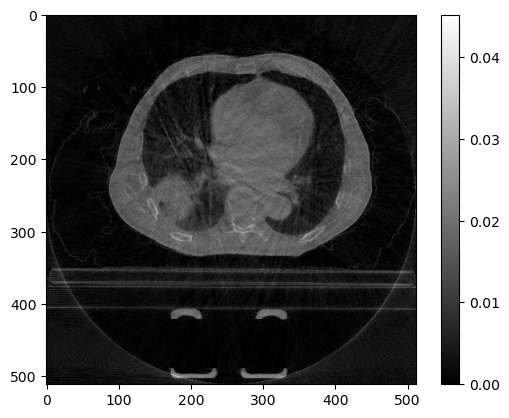

In [7]:
plt.imshow(recon[44].T,cmap='gray')
plt.colorbar()
plt.show()

In [ ]:
np.save('./data/recon_sks2.npy',recon)